AdaGrad with Gradient Differences
Standard AdaGrad accumulates the sum of squares of past gradients, which is used to adjust the learning rate:
$$
\begin{aligned}
& G_t=\sum_{i=1}^t g_i^2 \\
& \theta_{t+1}=\theta_t-\frac{\eta}{\sqrt{G_t+\epsilon}} \cdot g_t
\end{aligned}
$$

Modified AdaGrad with gradient differences accumulates the sum of squares of differences between successive gradients:
$$
\begin{aligned}
& D_t=\sum_{i=1}^t\left(\Delta g_i\right)^2
& \text{where} \; \Delta g_i=g_i-g_{i-1} \\
& \theta_{t+1}=\theta_t-\frac{\eta}{\sqrt{D_t+\epsilon}} \cdot g_t
\end{aligned}
$$


In [ ]:
import torch
from torch.optim import Optimizer

In [ ]:
class AdaGradWithDiff(Optimizer):
    def __init__(self, params, lr=1e-2, eps=1e-10):
        defaults = dict(lr=lr, eps=eps)
        super(AdaGradWithDiff, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if 'sum_grad_diffs' not in state:
                    state['sum_grad_diffs'] = torch.zeros_like(p.data)

                if 'prev_grad' not in state:
                    state['prev_grad'] = torch.zeros_like(p.data)

                grad_diff = grad - state['prev_grad']
                state['sum_grad_diffs'].addcmul_(grad_diff, grad_diff)

                std = state['sum_grad_diffs'].sqrt().add_(group['eps'])
                p.data.addcdiv_(-group['lr'], grad, std)

                state['prev_grad'] = grad.clone()

In [ ]:
class AdamWithDiff(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(AdamWithDiff, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if 'sum_grad_diffs' not in state:
                    state['sum_grad_diffs'] = torch.zeros_like(p.data)

                if 'exp_avg' not in state:
                    state['exp_avg'] = torch.zeros_like(p.data)
                if 'exp_avg_diff' not in state:
                    state['exp_avg_diff'] = torch.zeros_like(p.data)
                if 'prev_grad' not in state:
                    state['prev_grad'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_diff = state['exp_avg'], state['exp_avg_diff']
                beta1, beta2 = group['betas']

                grad_diff = grad - state['prev_grad']
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_diff.mul_(beta2).addcmul_(1 - beta2, grad_diff, grad_diff)

                denom = exp_avg_diff.sqrt().add_(group['eps'])

                step_size = group['lr'] / denom

                p.data.addcdiv_(-step_size, exp_avg, denom)

                state['prev_grad'] = grad.clone()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import time
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model architecture
class SimpleCNN(nn.Module):
    def __init__(self, use_batch_norm=False):
        super(SimpleCNN, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.bn1 = nn.BatchNorm2d(32) if use_batch_norm else nn.Identity()
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.bn2 = nn.BatchNorm2d(64) if use_batch_norm else nn.Identity()
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)

In [ ]:
# Prepare data loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Initialize the model, loss function, and optimizers
model_standard = SimpleCNN(use_batch_norm=True).to(device)
model_diff = SimpleCNN(use_batch_norm=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_standard = optim.Adagrad(model_standard.parameters(), lr=0.01)
optimizer_diff = AdaGradWithDiff(model_diff.parameters(), lr=0.01)

In [ ]:
# Training loop
def train(model, train_loader, optimizer, criterion, epoch, log_interval=100):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    return train_loss / len(train_loader)

# Evaluation loop
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')
    return test_loss, accuracy

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300697
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.193743
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.255579
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.187172
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.082305
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.088782
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.095130
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.044738
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.056218
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.066478

Test set: Average loss: 0.0001, Accuracy: 9834/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.018776
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.145029
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.080757
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.026075
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.023287
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.006744
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.022427
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.019066
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.010520
T

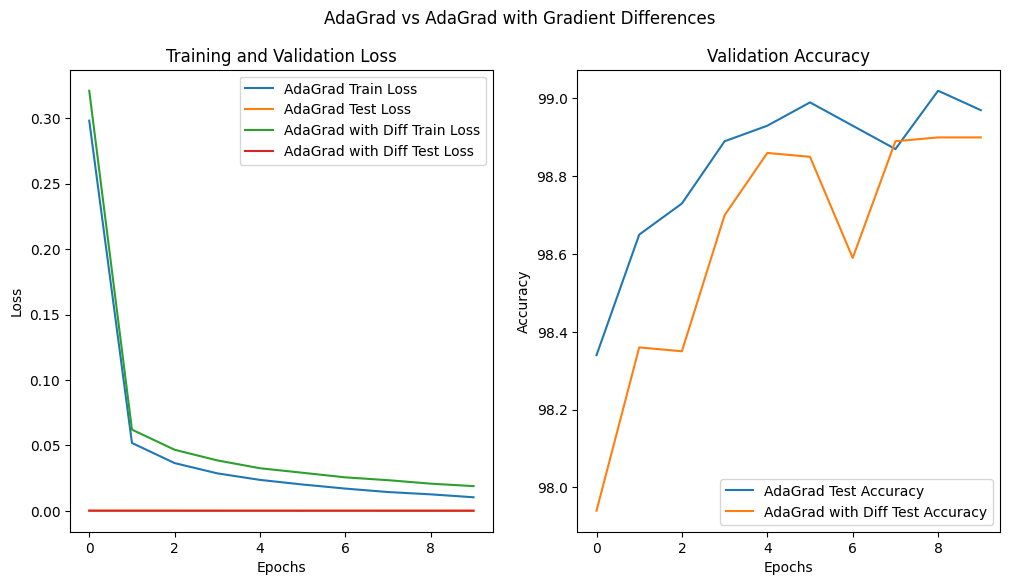

In [ ]:
# Track training and validation loss
train_losses_standard = []
test_losses_standard = []
test_accuracies_standard = []
train_losses_diff = []
test_losses_diff = []
test_accuracies_diff = []

# Measure time
start_time_standard = time.time()
for epoch in range(1, 11):
    train_loss = train(model_standard, train_loader, optimizer_standard, criterion, epoch)
    test_loss, test_accuracy = evaluate(model_standard, test_loader, criterion)
    train_losses_standard.append(train_loss)
    test_losses_standard.append(test_loss)
    test_accuracies_standard.append(test_accuracy)
end_time_standard = time.time()
time_standard = end_time_standard - start_time_standard

start_time_diff = time.time()
for epoch in range(1, 11):
    train_loss = train(model_diff, train_loader, optimizer_diff, criterion, epoch)
    test_loss, test_accuracy = evaluate(model_diff, test_loader, criterion)
    train_losses_diff.append(train_loss)
    test_losses_diff.append(test_loss)
    test_accuracies_diff.append(test_accuracy)
end_time_diff = time.time()
time_diff = end_time_diff - start_time_diff

# Plotting the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses_standard, label='AdaGrad Train Loss')
plt.plot(test_losses_standard, label='AdaGrad Test Loss')
plt.plot(train_losses_diff, label='AdaGrad with Diff Train Loss')
plt.plot(test_losses_diff, label='AdaGrad with Diff Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies_standard, label='AdaGrad Test Accuracy')
plt.plot(test_accuracies_diff, label='AdaGrad with Diff Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.suptitle('AdaGrad vs AdaGrad with Gradient Differences')
plt.show()

In [ ]:
print(f'Time taken by standard AdaGrad: {time_standard:.2f} seconds')
print(f'Time taken by AdaGrad with Gradient Differences: {time_diff:.2f} seconds')

Time taken by standard AdaGrad: 199.67 seconds
Time taken by AdaGrad with Gradient Differences: 199.73 seconds
